In [1]:
import pandas as pd
import numpy as np
import scipy.interpolate
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)
import matplotlib.pyplot as plt
from pandas.tseries.offsets import BDay

import wrds
import os
from dotenv import load_dotenv
load_dotenv()
WRDS_USER = os.environ.get("WRDS_USER")

/home/ygnmax/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
db = wrds.Connection(wrds_username = WRDS_USER)

In [6]:
import sys
sys.path.append("mylib")
from load_from_wrds import *

secid = 113993

zero_curve = query_zero_curve(db, startdate = '2019-01-01', enddate = '2022-12-31')
df_option = query_options(db, secid, startdate = '2019-01-01', enddate = '2022-12-31')
df_stock = query_stock(db, secid, startdate = '2019-01-01', enddate = '2022-12-31')
df_dividend = query_dividend(db, secid, startdate = '2019-01-01', enddate = '2022-12-31')

ProgrammingError: (psycopg2.errors.UndefinedColumn) column "cfadj2" does not exist
LINE 2:     SELECT secid, date, close, cfadj2
                                       ^
HINT:  Perhaps you meant to reference the column "secprd.cfadj".

[SQL: 
    SELECT secid, date, close, cfadj2
    FROM optionm.secprd
    WHERE secid=113993
    AND date BETWEEN '2019-01-01' AND '2022-12-31'
    ORDER BY date ASC
    ]
(Background on this error at: https://sqlalche.me/e/14/f405)

In [5]:

stock_column={"secid": "SecurityID",
              "date": "Date",
              "low" : "BidLow",
              "high" : "AskHigh",
              "open" : "OpenPrice",
              "high" :  "AskHigh",
              "close" : "ClosePrice",
              "volume" : "Volume",
              "return": "TotalReturn",
              "cfadj" : "AdjustmentFactor",
              "shrout" : "SharesOutstanding",
              "cfret" : "AdjustmentFactor2" 
             }
option_column={"secid": "SecurityID",
               "date": "Date",
               "exdate" : "Expiration",
               "strike_price" :  "Strike",
               "cp_flag" : "CallPut",
               "best_bid" : "BestBid",
               "best_offer" : "BestOffer",
               "impl_volatility" : "ImpliedVolatility",
               "delta" : "Delta",
               "gamma" : "Gamma",
               "vega" : "Vega",
               "theta" : "Theta",
               "volume" : "Volume",
               "open_interest": "OpenInterest",
               "last_date" : "LastTradeDate",
               "contract_size" : "ContractSize",
               "optionid" : "OptionID" 
               }
div_column={"secid": "SecurityID",
            "record_date": "RecordDate",
            "ticker" : "Ticker",
            "issuer" :  "IssuerDescription",
            "distr_type": "DistributionType",
            "amount" : "Amount",
            "ex_date": "ExDate",
            "declare_date": "DeclareDate",
            "payment_date": "PaymentDate"
            }
zero_column={"date": "Date", "days": "Days",  "rate" : "Rate"}
df_stock.rename(columns=stock_column, inplace=True)
df_stock['AdjClosePrice'] = df_stock['close'] * df_stock['AdjustmentFactor'] / df_stock.loc[len(df_stock)-1, 'AdjustmentFactor']
df_stock['AdjClosePrice2'] = df_stock['close'] * df_stock['AdjustmentFactor2'] / df_stock.loc[len(df_stock)-1, 'AdjustmentFactor2']
df_option.rename(columns=option_column, inplace=True)
df_dividend.rename(columns=div_column, inplace=True)
zero_curve.rename(columns=zero_column, inplace=True)

In [11]:
def preclean_data(df_option, df_stock, stkid, day_count = 360):
    #########################
    ## Step 1: Preclean Data
    #########################
    #--------------------------
    ## 1.1 Preclean option data
    #--------------------------
    df = df_option.copy()
    df = df.drop_duplicates()
    df['date'] = pd.to_datetime(df['date'])
    df['exdate'] = pd.to_datetime(df['exdate'])
    df['last_date'] = pd.to_datetime(df['last_date'])
    df['K'] = df['strike_price'] / 1000.0
    df['V0'] = (df['best_bid'] + df['best_offer'])/2
    df['Maturity'] = df['exdate'] - df['date']
    df['Maturity'] = df.Maturity.dt.days
    df['tau'] = df['Maturity'] / day_count
    tau = np.busday_count(df['date'].values.astype('datetime64[D]'), 
                      df['exdate'].values.astype('datetime64[D]'))
    df['tau0'] = tau / day_count  
    
    df['IV0'] = df['impl_volatility']
    df = df[['date', 'K', 'exdate',
           'cp_flag', 'best_bid', 'best_offer', 'last_date', 'volume',
           'IV0', 'delta', 'optionid', 
           'V0', 'Maturity', 'tau', 'tau0']]
    df = df.sort_values(by = ['date', 'exdate', 'cp_flag', 'K'])

    #------------------------------------
    ## 1.2 Preclean index/underlying data
    #------------------------------------
    df_stk = df_stock.copy()
    df_stk['date'] = pd.to_datetime(df_stk['date'])
    df_stk['S0'] = df_stk['close']
    
    #######################################################
    # Step 2: Merge Dataframes and add future volume/value
    #######################################################
    #----------------------------------------------------
    # 2.1 merge option price with index/underlying price
    #----------------------------------------------------
    df = df.merge(df_stk[['date', 'S0', 'AdjClosePrice', 'AdjClosePrice2', 'AdjustmentFactor', 'AdjustmentFactor2']], 
                  how = 'left', on = 'date')
    # print(df.shape)

    #------------------------
    # 2.2 Add Tomorrow Value
    #------------------------
    tmp = ['date', 'optionid', 'S0', 'V0', 'IV0', 'volume']
    new_cols = {
        'S0': 'S1', 
        'V0': 'V1', 
        'IV0': 'IV1',
        'volume': 'Volume1'}    

    df_tmp = df[tmp].copy()
    df_tmp['date'] -= BDay(1)

    df_tmp.rename(columns=new_cols, inplace=True)
    df_tmp.set_index(['date', 'optionid'], inplace=True)
    df = df.join(df_tmp, on=['date', 'optionid'])      
    
    return df

df = preclean_data(df_option, df_stock, secid)

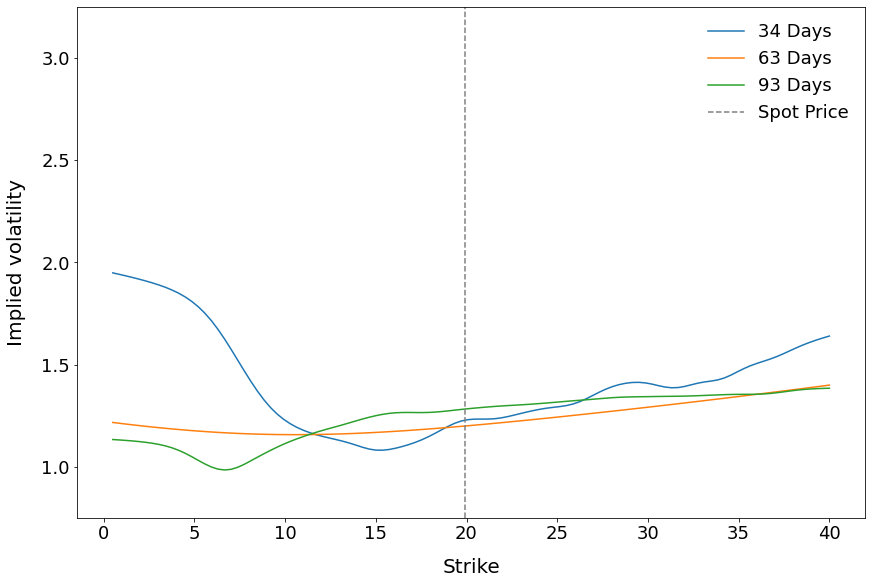

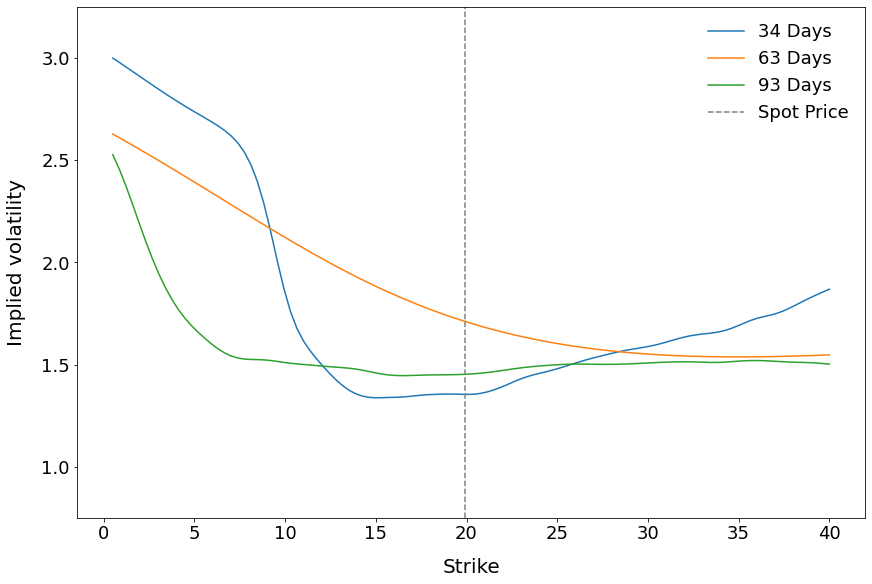

In [14]:
MEDIUM_SIZE = 18
BIGGER_SIZE = 20
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure title

temp = df.copy()
date_list = ['2021-01-11']
for date in date_list:
    for cpflag in ['C', 'P']:
        row = temp.loc[(temp['date'] == date) & (temp['cp_flag'] == cpflag), ['date', 'K', 'S0', 'V0', 'Maturity', 'IV0', 'delta']]
        xi = np.linspace(min(row.Maturity), max(row.Maturity), 100)    
        yi = np.linspace(min(row.K), max(row.K), 110)
        X, Y = np.meshgrid(xi, yi)
        row = row.dropna()
        S0 = np.unique(row.S0)
        
        # IV, maturity, strike
        spline = scipy.interpolate.Rbf(row.Maturity, row.K, row.IV0, function='linear')
        Z = spline(X,Y)
        
        # Volatility Skew
        maturitylist = np.unique(X)
        fig = plt.figure(figsize=(12, 8), constrained_layout=True)
        ax = fig.add_subplot(111)
        idx = np.argmin(np.abs(np.array(maturitylist)-30))
        plt.plot(Y[:,idx], Z[:,idx], label = str(round(maturitylist[idx])) + ' Days')
        idx = np.argmin(np.abs(np.array(maturitylist)-60))
        plt.plot(Y[:,idx], Z[:,idx], label = str(round(maturitylist[idx])) + ' Days')
        idx = np.argmin(np.abs(np.array(maturitylist)-90))
        plt.plot(Y[:,idx], Z[:,idx], label =  str(round(maturitylist[idx])) + ' Days')
        plt.axvline(x = S0, color = 'grey', linestyle = '--', label = 'Spot Price')
        ax.set_xlabel('strike_price', labelpad=15)
        ax.set_ylabel('Implied volatility', labelpad=15)
        ax.set_ylim([0.75, 3.25]) 
        
        plt.legend(frameon=False)
        # plt.savefig(output_path + str(securityid) + '/' + str(securityid) + '_vol_skew' + '_' + date + '_' + cpflag + '.jpg', dpi=300, bbox_inches='tight')
        # plt.close()